In [1]:
# State-level risk tiering using FBI NIBRS + Census population
# This notebook unzips your download, reshapes it, joins state population, and assigns tiers.

from pathlib import Path
import zipfile
import os

# Adjust if you put the ZIP somewhere else
ZIP_PATH = r"C:\Users\Owner\Downloads\incidents.zip"

# Working folders in your project (relative to this notebook)
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
EXTRACT_DIR = DATA_DIR / "incidents_state"; EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

print("ZIP path:", ZIP_PATH)
print("Extract to:", EXTRACT_DIR.resolve())


ZIP path: C:\Users\Owner\Downloads\incidents.zip
Extract to: C:\Users\Owner\data\incidents_state


In [2]:
import sys, subprocess

def pip_install(pkg):
    print(f"Installing {pkg} if needed...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# pandas, requests, matplotlib should already be installed from earlier
# openpyxl is the engine pandas uses to read .xlsx files
try:
    import openpyxl  # noqa
except ImportError:
    pip_install("openpyxl")


In [3]:
# Unzip your incidents.zip into EXTRACT_DIR
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

files = list(EXTRACT_DIR.glob("*.xlsx"))
if not files:
    raise FileNotFoundError("No .xlsx file found inside the ZIP. Check ZIP contents.")
xls_path = files[0]
xls_path


WindowsPath('data/incidents_state/NIBRS_Table_3_Incidents_Offenses_Victims_and_Known_Offenders_by_Offense_Category_2024.xlsx')

In [4]:
import pandas as pd
import numpy as np

# xls_path should already point to:
# "incidents_extracted/NIBRS_Table_3_Incidents_Offenses_Victims_and_Known_Offenders_by_Offense_Category_2024.xlsx"

# Read without guessing headers, then set the real header row
raw0 = pd.read_excel(xls_path, sheet_name=0, header=None)

# From inspection, row index 3 contains the real column names
hdr = raw0.iloc[3].astype(str).tolist()
df = pd.read_excel(xls_path, sheet_name=0, header=3)

# Drop blank columns like "Unnamed: ..."
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]

# Clean column names
clean_map = {
    "Offense Category": "offense_category",
    "Incidents1": "incidents",
    "Offenses": "offenses",
    "Victims2": "victims",
    "Known\nOffenders3": "known_offenders",
    "Known Offenders3": "known_offenders",
}
df.columns = [clean_map.get(c, str(c).strip()) for c in df.columns]

# Keep only the rows that are actual categories or the total
df = df.dropna(how="all")
df = df[["offense_category","incidents","offenses","victims","known_offenders"]]

# Coerce numeric columns
for c in ["incidents","offenses","victims","known_offenders"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Separate out the Total row for validation, keep the category rows
total_row = df.loc[df["offense_category"].str.strip().str.lower().eq("total")]
cats = df.loc[~df["offense_category"].str.strip().str.lower().eq("total")].copy()

# Quick sanity
display(cats.head(10))
display(total_row)


,offense_category,incidents,offenses,victims,known_offenders
1,Crimes Against Persons,3577008.0,4097814.0,4097814.0,3805526.0
2,Assault Offenses,3302140.0,3804923.0,3804923.0,3529162.0
3,Homicide Offenses,16267.0,17588.0,17588.0,18973.0
4,Human Trafficking Offenses,3062.0,3563.0,3563.0,3404.0
5,Kidnapping/Abduction,47803.0,52474.0,52474.0,53098.0
6,Sex Offenses,207736.0,219266.0,219266.0,200889.0
7,Crimes Against Property,8237977.0,8237977.0,8926112.0,5110695.0
8,Arson,31982.0,31982.0,38692.0,22746.0
9,Bribery,849.0,849.0,910.0,913.0
10,Burglary/Breaking & Entering,655847.0,655847.0,764570.0,424130.0


,offense_category,incidents,offenses,victims,known_offenders
0,Total,12225903.0,14361136.0,15049355.0,11264265.0


In [5]:
# Shares by category
tot_inc = cats["incidents"].sum()
tot_off = cats["offenses"].sum()
tot_vic = cats["victims"].sum()
tot_kno = cats["known_offenders"].sum()

cats["incident_share"] = cats["incidents"] / tot_inc
cats["offense_share"]  = cats["offenses"]  / tot_off
cats["victim_share"]   = cats["victims"]   / tot_vic

# Long format for plotting or export
long = cats.melt(
    id_vars=["offense_category"],
    value_vars=["incidents","offenses","victims","known_offenders"],
    var_name="metric",
    value_name="value"
)

display(cats.sort_values("incidents", ascending=False).head(10))


,offense_category,incidents,offenses,victims,known_offenders,incident_share,offense_share,victim_share
7,Crimes Against Property,8237977.0,8237977.0,8926112.0,5110695.0,0.297608,0.286815,0.296561
16,Larceny/Theft Offenses,3832550.0,3832550.0,4071229.0,2375186.0,0.138456,0.133435,0.135263
1,Crimes Against Persons,3577008.0,4097814.0,4097814.0,3805526.0,0.129224,0.142670,0.136146
2,Assault Offenses,3302140.0,3804923.0,3804923.0,3529162.0,0.119294,0.132473,0.126415
20,Crimes Against Society,2025345.0,2025345.0,2025429.0,2348044.0,0.073168,0.070515,0.067293
22,Drug/Narcotic Offenses,1577175.0,1577175.0,1577191.0,1870804.0,0.056978,0.054911,0.052401
12,Destruction/Damage/Vandalism,1567082.0,1567082.0,1703699.0,934892.0,0.056613,0.054560,0.056604
15,Fraud Offenses,891661.0,891661.0,967387.0,458317.0,0.032212,0.031044,0.032140
17,Motor Vehicle Theft,750704.0,750704.0,783253.0,342526.0,0.027120,0.026137,0.026023
10,Burglary/Breaking & Entering,655847.0,655847.0,764570.0,424130.0,0.023693,0.022834,0.025402


In [6]:
# Robust fetch: try Vintage 2024, then fall back to 2023
urls = [
    "https://www2.census.gov/programs-surveys/popest/datasets/2020-2024/state/totals/NST-EST2024-ALLDATA.csv",
    "https://www2.census.gov/programs-surveys/popest/datasets/2020-2023/state/totals/NST-EST2023-ALLDATA.csv",
]

pop_raw = None
err = None
for u in urls:
    try:
        pop_raw = pd.read_csv(u)
        print("Loaded:", u)
        break
    except Exception as e:
        print("Failed:", u)
        err = e

if pop_raw is None:
    raise err

# Get the most recent POPESTIMATE column
pop_cols = sorted([c for c in pop_raw.columns if str(c).startswith("POPESTIMATE")])
recent_col = pop_cols[-1]

# U.S. total row is "United States"
us_pop = (
    pop_raw.rename(columns={"NAME":"name"})
           .loc[lambda d: d["name"].astype(str).str.strip().eq("United States"), [recent_col]]
           .squeeze()
)

US_POP = float(us_pop)
print("US population used:", US_POP)

# Compute incidents per 100k by offense category
cats["incidents_per_100k"] = cats["incidents"] / US_POP * 100000
cats["offenses_per_100k"]  = cats["offenses"]  / US_POP * 100000
cats["victims_per_100k"]   = cats["victims"]   / US_POP * 100000

display(cats.sort_values("incidents_per_100k", ascending=False).head(10))


Loaded: https://www2.census.gov/programs-surveys/popest/datasets/2020-2024/state/totals/NST-EST2024-ALLDATA.csv
US population used: 340110988.0


,offense_category,incidents,offenses,victims,known_offenders,incident_share,offense_share,victim_share,incidents_per_100k,offenses_per_100k,victims_per_100k
7,Crimes Against Property,8237977.0,8237977.0,8926112.0,5110695.0,0.297608,0.286815,0.296561,2422.143739,2422.143739,2624.470339
16,Larceny/Theft Offenses,3832550.0,3832550.0,4071229.0,2375186.0,0.138456,0.133435,0.135263,1126.852744,1126.852744,1197.029541
1,Crimes Against Persons,3577008.0,4097814.0,4097814.0,3805526.0,0.129224,0.142670,0.136146,1051.717859,1204.846107,1204.846107
2,Assault Offenses,3302140.0,3804923.0,3804923.0,3529162.0,0.119294,0.132473,0.126415,970.900711,1118.729807,1118.729807
20,Crimes Against Society,2025345.0,2025345.0,2025429.0,2348044.0,0.073168,0.070515,0.067293,595.495315,595.495315,595.520013
22,Drug/Narcotic Offenses,1577175.0,1577175.0,1577191.0,1870804.0,0.056978,0.054911,0.052401,463.723624,463.723624,463.728329
12,Destruction/Damage/Vandalism,1567082.0,1567082.0,1703699.0,934892.0,0.056613,0.054560,0.056604,460.756064,460.756064,500.924422
15,Fraud Offenses,891661.0,891661.0,967387.0,458317.0,0.032212,0.031044,0.032140,262.167655,262.167655,284.432739
17,Motor Vehicle Theft,750704.0,750704.0,783253.0,342526.0,0.027120,0.026137,0.026023,220.723242,220.723242,230.293354
10,Burglary/Breaking & Entering,655847.0,655847.0,764570.0,424130.0,0.023693,0.022834,0.025402,192.833229,192.833229,224.800147


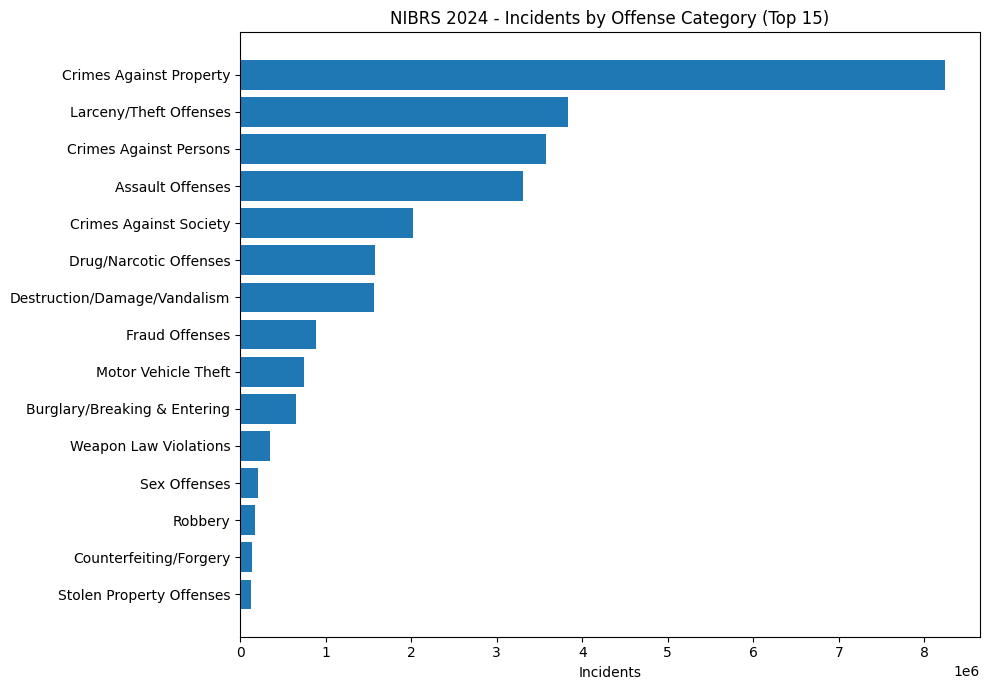

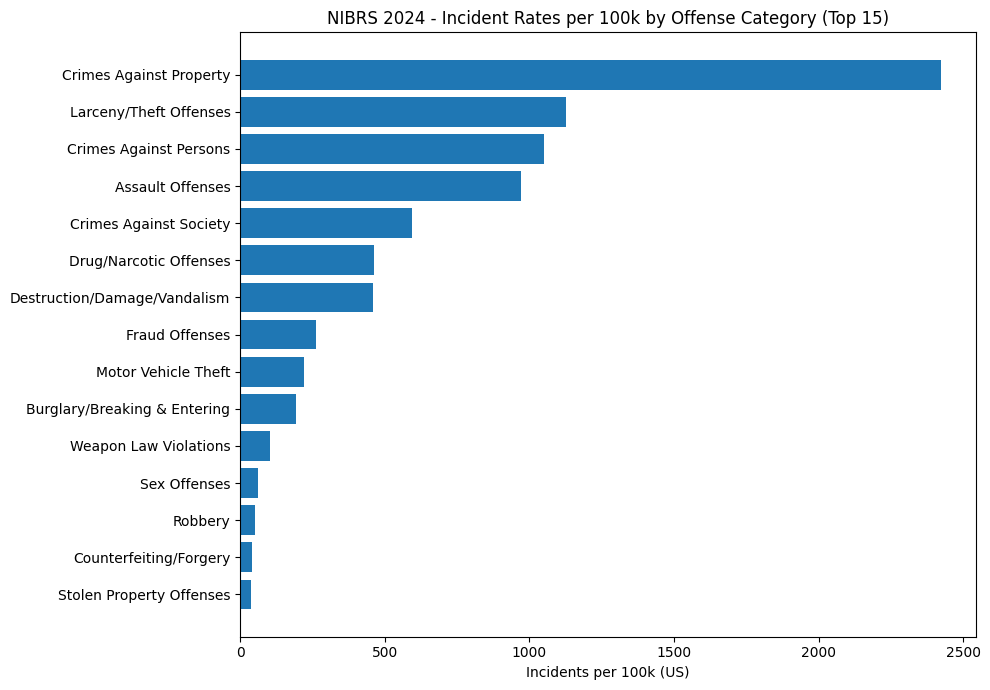

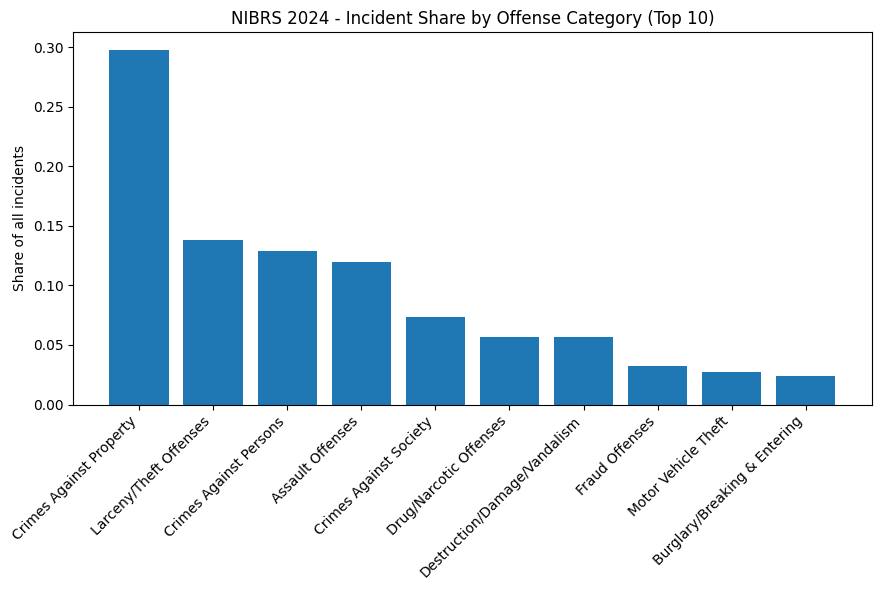

In [7]:
import matplotlib.pyplot as plt

top_inc = cats.sort_values("incidents", ascending=False).head(15)

# Bar - incidents by offense category
plt.figure(figsize=(10,7))
plt.barh(top_inc["offense_category"], top_inc["incidents"])
plt.gca().invert_yaxis()
plt.xlabel("Incidents")
plt.title("NIBRS 2024 - Incidents by Offense Category (Top 15)")
plt.tight_layout()
plt.show()

# Bar - incidents per 100k by offense category
top_rate = cats.sort_values("incidents_per_100k", ascending=False).head(15)
plt.figure(figsize=(10,7))
plt.barh(top_rate["offense_category"], top_rate["incidents_per_100k"])
plt.gca().invert_yaxis()
plt.xlabel("Incidents per 100k (US)")
plt.title("NIBRS 2024 - Incident Rates per 100k by Offense Category (Top 15)")
plt.tight_layout()
plt.show()

# Shares
share = cats.sort_values("incident_share", ascending=False).head(10)
plt.figure(figsize=(9,6))
plt.bar(share["offense_category"], share["incident_share"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share of all incidents")
plt.title("NIBRS 2024 - Incident Share by Offense Category (Top 10)")
plt.tight_layout()
plt.show()


In [8]:
from pathlib import Path

OUT = Path("outputs"); OUT.mkdir(exist_ok=True)
cats.to_csv(OUT / "nibrs_2024_offense_category_national.csv", index=False)
long.to_csv(OUT / "nibrs_2024_offense_category_national_long.csv", index=False)

print("Wrote:")
print((OUT / "nibrs_2024_offense_category_national.csv").resolve())
print((OUT / "nibrs_2024_offense_category_national_long.csv").resolve())


Wrote:
C:\Users\Owner\outputs\nibrs_2024_offense_category_national.csv
C:\Users\Owner\outputs\nibrs_2024_offense_category_national_long.csv
